This notebook follows the tutorial on RNA2seg documentation to run default segmentation model and evaluate its performance.

Reference: https://rna2seg.readthedocs.io/en/latest/notebook/apply_model_on_zarr.html

In [1]:
import rna2seg
rna2seg.__version__

'0.1.5'

In [2]:
import cv2
import spatialdata as sd
import spatialdata_io as sdio
from pathlib import Path

/Users/whchou/miniconda3/envs/rna2seg/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/whchou/miniconda3/envs/rna2seg/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


In [7]:
import os

wd = '../'
os.chdir(wd)

# Test on a small cropped region

In [9]:
xe_data = sd.read_zarr('data/SN151/xenium.zarr')

version mismatch: detected: RasterFormatV02, requested: FormatV04
/Users/whchou/miniconda3/envs/rna2seg/lib/python3.10/site-packages/zarr/creation.py:300: UserWarning: ignoring keyword argument 'read_only'
  warn(f"ignoring keyword argument {k!r}")
/Users/whchou/miniconda3/envs/rna2seg/lib/python3.10/site-packages/zarr/creation.py:300: UserWarning: ignoring keyword argument 'read_only'
  warn(f"ignoring keyword argument {k!r}")
/Users/whchou/miniconda3/envs/rna2seg/lib/python3.10/site-packages/zarr/creation.py:300: UserWarning: ignoring keyword argument 'read_only'
  warn(f"ignoring keyword argument {k!r}")
/Users/whchou/miniconda3/envs/rna2seg/lib/python3.10/site-packages/zarr/creation.py:300: UserWarning: ignoring keyword argument 'read_only'
  warn(f"ignoring keyword argument {k!r}")
/Users/whchou/miniconda3/envs/rna2seg/lib/python3.10/site-packages/zarr/creation.py:300: UserWarning: ignoring keyword argument 'read_only'
  warn(f"ignoring keyword argument {k!r}")
/Users/whchou/minic

In [10]:
xe_data

SpatialData object, with associated Zarr store: /Users/whchou/Spatial_omics_segmentation/rna2seg/data/SN151/xenium.zarr
├── Images
│     └── 'morphology_focus': DataTree[cyx] (4, 27341, 28499), (4, 13670, 14249), (4, 6835, 7124), (4, 3417, 3562), (4, 1708, 1781)
├── Labels
│     ├── 'cell_labels': DataTree[yx] (27341, 28499), (13670, 14249), (6835, 7124), (3417, 3562), (1708, 1781)
│     └── 'nucleus_labels': DataTree[yx] (27341, 28499), (13670, 14249), (6835, 7124), (3417, 3562), (1708, 1781)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 11) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (91779, 1) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (90888, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (91779, 477)
with coordinate systems:
    ▸ 'global', with elements:
        morphology_focus (Images), cell_labels (Labels), nucleus_labels (Labels), transcripts (Points), cell_boundaries (Shapes), nucleus_boundaries (

## Visualize region to crop

In [5]:
xe_data.images["morphology_focus"]["scale0"]["image"]

<xarray.DataArray 'image' (c: 5, y: 27341, x: 28499)> Size: 8GB
dask.array<from-zarr, shape=(5, 27341, 28499), dtype=uint16, chunksize=(1, 4096, 4096), chunktype=numpy.ndarray>
Coordinates:
  * c        (c) <U22 440B 'DAPI' 'ATP1A1/CD45/E-Cadherin' ... 'dummy'
  * y        (y) float64 219kB 0.5 1.5 2.5 3.5 ... 2.734e+04 2.734e+04 2.734e+04
  * x        (x) float64 228kB 0.5 1.5 2.5 3.5 ... 2.85e+04 2.85e+04 2.85e+04
Attributes:
    transform:  {'global': Identity }

Selected DAPI channel by name: DAPI


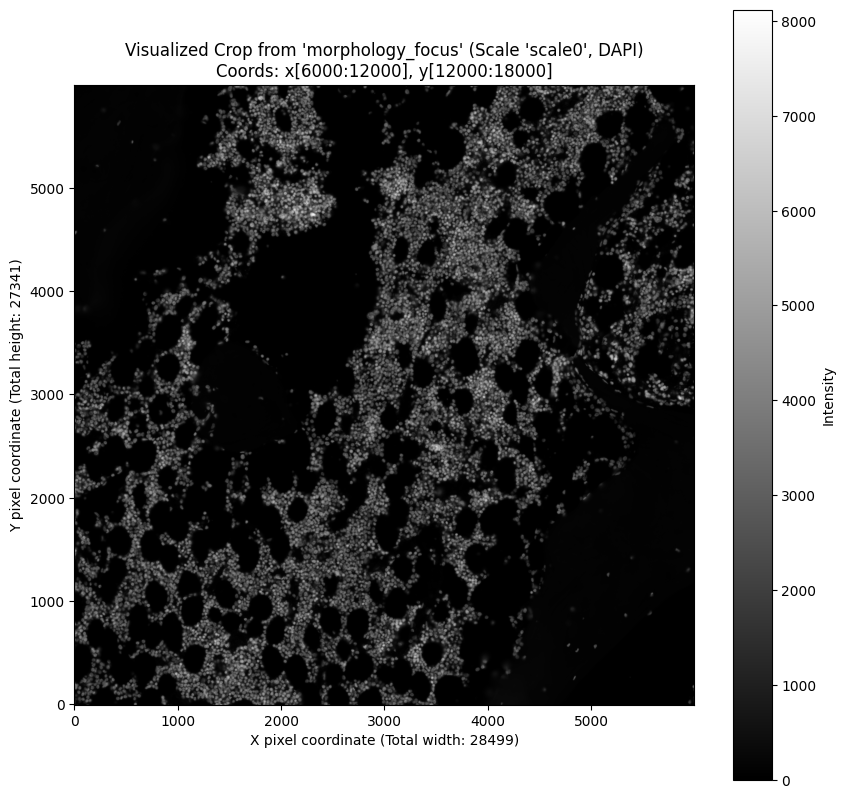

Displaying cropped region of shape: (6000, 6000)
Original full DAPI channel shape: (27341, 28499)


In [11]:
# Visualize cropped region
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Ensure xe_data is loaded, and channels_dapi is defined as in your notebook
# e.g., channels_dapi = ["DAPI"]

image_key = "morphology_focus"

channels_dapi= ["DAPI"]
channels_cellbound=["ATP1A1/CD45/E-Cadherin"]

# --- Define your desired Field of View (FOV) ---
# These are pixel coordinates for the highest resolution scale ('scale0')
# You'll want to adjust these to explore different regions.
fov_xmin = 6000
fov_ymin = 12000
fov_width = 6000  # Desired width of the FOV
fov_height = 6000 # Desired height of the FOV

fov_xmax = fov_xmin + fov_width
fov_ymax = fov_ymin + fov_height
# --- End FOV definition ---

try:
    # Access the top-level DataTree for the image
    full_image_datatree = xe_data.images[image_key]

    # Access the DataTree for the highest resolution scale ('scale0')
    # This node contains an xarray.Dataset
    scale0_node_datatree = full_image_datatree['scale0']

    # Access the xarray.DataArray from the Dataset within the scale0 node
    image_data_xr = scale0_node_datatree["image"]
    # image_data_xr is an xarray.DataArray, likely with dimensions (c, y, x)

    # Select the DAPI channel for visualization
    # Using the 'channels_dapi' list defined in your notebook
    selected_channel_data = None
    if 'channels_dapi' in locals() and channels_dapi:
        try:
            dapi_channel_name = channels_dapi[0] # e.g., "DAPI"
            selected_channel_data = image_data_xr.sel(c=dapi_channel_name)
            print(f"Selected DAPI channel by name: {dapi_channel_name}")
        except KeyError:
            print(f"DAPI channel name '{channels_dapi[0]}' not found in 'c' coordinate. Trying by index.")
            selected_channel_data = image_data_xr.isel(c=0) # Fallback to first channel
            print("Selected DAPI channel by index 0.")
    else:
        print("'channels_dapi' not defined or empty. Selecting first channel by index.")
        selected_channel_data = image_data_xr.isel(c=0) # Fallback to first channel

    # Get image dimensions for bounds checking
    img_total_height = selected_channel_data.sizes['y']
    img_total_width = selected_channel_data.sizes['x']

    # Ensure FOV coordinates are within the image bounds
    # .isel uses 0-based indexing and exclusive upper bounds for slices
    actual_ymin = max(0, fov_ymin)
    actual_ymax = min(img_total_height, fov_ymax)
    actual_xmin = max(0, fov_xmin)
    actual_xmax = min(img_total_width, fov_xmax)

    if actual_ymin >= actual_ymax or actual_xmin >= actual_xmax:
        print(f"Invalid FOV coordinates after clamping. "
              f"Original Dims: H={img_total_height}, W={img_total_width}. "
              f"Requested FOV: y[{fov_ymin}:{fov_ymax}], x[{fov_xmin}:{fov_xmax}]. "
              f"Clamped FOV: y[{actual_ymin}:{actual_ymax}], x[{actual_xmin}:{actual_xmax}].")
    else:
        # Crop the selected channel using pixel indices
        # slice(start, stop) for isel means elements from start up to (but not including) stop
        cropped_region_xr = selected_channel_data.isel(
            y=slice(actual_ymin, actual_ymax),
            x=slice(actual_xmin, actual_xmax)
        )
        
        # Convert to NumPy array for plotting
        cropped_region_np = cropped_region_xr.data

        # Visualize
        plt.figure(figsize=(10, 10))
        plt.imshow(cropped_region_np, cmap='gray', origin='lower') # origin='lower' if y=0 is bottom
        plt.title(f"Visualized Crop from '{image_key}' (Scale 'scale0', DAPI)\n"
                  f"Coords: x[{actual_xmin}:{actual_xmax}], y[{actual_ymin}:{actual_ymax}]")
        plt.xlabel(f"X pixel coordinate (Total width: {img_total_width})")
        plt.ylabel(f"Y pixel coordinate (Total height: {img_total_height})")
        plt.colorbar(label="Intensity")
        plt.show()
        
        print(f"Displaying cropped region of shape: {cropped_region_np.shape}")
        print(f"Original full DAPI channel shape: {selected_channel_data.shape}")

except KeyError as e:
    print(f"KeyError: {e}. Could not access the specified image key or scale.")
    print(f"Available image keys in xe_data.images: {list(xe_data.images.keys())}")
    if image_key in xe_data.images:
        print(f"Available scales in '{image_key}': {list(xe_data.images[image_key].keys())}")
except Exception as e:
    print(f"An error occurred: {e}")

## Create Zarr with cropped data using spataildata's subsampling scheme

In [12]:
fov_xmin = 6000
fov_ymin = 12000
fov_width = 6000  # Desired width of the FOV
fov_height = 6000 # Desired height of the FOV

fov_xmax = fov_xmin + fov_width
fov_ymax = fov_ymin + fov_height

cropped_sdata = xe_data.query.bounding_box(
    axes=["x", "y"],
    min_coordinate=[fov_xmin, fov_ymin],
    max_coordinate=[fov_xmax, fov_ymax],
    target_coordinate_system="global",
)

cropped_sdata


/Users/whchou/miniconda3/envs/rna2seg/lib/python3.10/functools.py:889: UserWarning: The object has `points` element. Depending on the number of points, querying MAY suffer from performance issues. Please consider filtering the object before calling this function by calling the `subset()` method of `SpatialData`.
  return dispatch(args[0].__class__)(*args, **kw)


SpatialData object
├── Images
│     └── 'morphology_focus': DataTree[cyx] (4, 6000, 6000), (4, 3000, 3000), (4, 1500, 1500), (4, 750, 750), (4, 374, 375)
├── Labels
│     ├── 'cell_labels': DataTree[yx] (6000, 6000), (3000, 3000), (1500, 1500), (750, 750), (374, 375)
│     └── 'nucleus_labels': DataTree[yx] (6000, 6000), (3000, 3000), (1500, 1500), (750, 750), (374, 375)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 11) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (11300, 1) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (11157, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (11298, 477)
with coordinate systems:
    ▸ 'global', with elements:
        morphology_focus (Images), cell_labels (Labels), nucleus_labels (Labels), transcripts (Points), cell_boundaries (Shapes), nucleus_boundaries (Shapes)

In [13]:
cropped_sdata.write('data/SN151/xenium_cropped.zarr')

INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside data/SN151/xenium_cropped.zarr). Please see the documentation of `is_self_contained()`  
         to understand the implications of working with SpatialData objects that are not self-contained.           
INFO     The Zarr backing store has been changed from None the new file path: data/SN151/xenium_cropped.zarr       


## Run rna2seg from cropped data

In [14]:
cropped_sdata = sd.read_zarr('data/SN151/xenium_cropped.zarr')

version mismatch: detected: RasterFormatV02, requested: FormatV04
/Users/whchou/miniconda3/envs/rna2seg/lib/python3.10/site-packages/zarr/creation.py:300: UserWarning: ignoring keyword argument 'read_only'
  warn(f"ignoring keyword argument {k!r}")
/Users/whchou/miniconda3/envs/rna2seg/lib/python3.10/site-packages/zarr/creation.py:300: UserWarning: ignoring keyword argument 'read_only'
  warn(f"ignoring keyword argument {k!r}")
/Users/whchou/miniconda3/envs/rna2seg/lib/python3.10/site-packages/zarr/creation.py:300: UserWarning: ignoring keyword argument 'read_only'
  warn(f"ignoring keyword argument {k!r}")
/Users/whchou/miniconda3/envs/rna2seg/lib/python3.10/site-packages/zarr/creation.py:300: UserWarning: ignoring keyword argument 'read_only'
  warn(f"ignoring keyword argument {k!r}")
/Users/whchou/miniconda3/envs/rna2seg/lib/python3.10/site-packages/zarr/creation.py:300: UserWarning: ignoring keyword argument 'read_only'
  warn(f"ignoring keyword argument {k!r}")
/Users/whchou/minic

In [15]:
cropped_sdata

SpatialData object, with associated Zarr store: /Users/whchou/Spatial_omics_segmentation/rna2seg/data/SN151/xenium_cropped.zarr
├── Images
│     └── 'morphology_focus': DataTree[cyx] (4, 6000, 6000), (4, 3000, 3000), (4, 1500, 1500), (4, 750, 750), (4, 374, 375)
├── Labels
│     ├── 'cell_labels': DataTree[yx] (6000, 6000), (3000, 3000), (1500, 1500), (750, 750), (374, 375)
│     └── 'nucleus_labels': DataTree[yx] (6000, 6000), (3000, 3000), (1500, 1500), (750, 750), (374, 375)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 11) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (11300, 1) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (11157, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (11298, 477)
with coordinate systems:
    ▸ 'global', with elements:
        morphology_focus (Images), cell_labels (Labels), nucleus_labels (Labels), transcripts (Points), cell_boundaries (Shapes), nucleus_boundaries (Shapes)

In [16]:
image_key = "morphology_focus"
points_key = "transcripts"

channels_dapi= ["DAPI"]
channels_cellbound=["ATP1A1/CD45/E-Cadherin"]

gene_column_name="feature_name"

patch_width = 1200
patch_overlap = 150
min_points_per_patch = 0
folder_patch_rna2seg = Path(wd) / f".rna2seg_cropped{patch_width}_{patch_overlap}"

### Create patches

In [17]:
from rna2seg.dataset_zarr.patches import create_patch_rna2seg

### create patch in the sdata and precompute transcipt.csv for each patch with sopa
create_patch_rna2seg(sdata=cropped_sdata,
                    image_key=image_key,
                    points_key=points_key,
                    patch_width=patch_width,
                    patch_overlap=patch_overlap,
                    min_points_per_patch=min_points_per_patch,
                    folder_patch_rna2seg = folder_patch_rna2seg,
                    overwrite = True,
                    gene_column_name=gene_column_name)


[INFO] (sopa.patches._patches) Added 36 patche(s) to sdata['sopa_patches_rna2seg_1200_150']


[########################################] | 100% Completed | 1.89 sms
[########################################] | 100% Completed | 1.83 ss


TranscriptPatchesWithScale object with 36 patches

In [18]:
print(cropped_sdata)

SpatialData object, with associated Zarr store: /Users/whchou/Spatial_omics_segmentation/rna2seg/data/SN151/xenium_cropped.zarr
├── Images
│     └── 'morphology_focus': DataTree[cyx] (4, 6000, 6000), (4, 3000, 3000), (4, 1500, 1500), (4, 750, 750), (4, 374, 375)
├── Labels
│     ├── 'cell_labels': DataTree[yx] (6000, 6000), (3000, 3000), (1500, 1500), (750, 750), (374, 375)
│     └── 'nucleus_labels': DataTree[yx] (6000, 6000), (3000, 3000), (1500, 1500), (750, 750), (374, 375)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 11) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (11300, 1) (2D shapes)
│     ├── 'nucleus_boundaries': GeoDataFrame shape: (11157, 1) (2D shapes)
│     └── 'sopa_patches_rna2seg_1200_150': GeoDataFrame shape: (36, 3) (2D shapes)
└── Tables
      └── 'table': AnnData (11298, 477)
with coordinate systems:
    ▸ 'global', with elements:
        morphology_focus (Images), cell_labels (Labels), nucleus_labels (Labels), t

### Initialize RNA2segDataset
!!! Note that resize_dim heavily affects performance of the pretrained model provided by the authors!!!

In [20]:
import albumentations as A
from rna2seg.dataset_zarr import RNA2segDataset
resize_dim = 1024

transform_resize  = A.Compose([
    A.Resize(width=resize_dim, height=resize_dim, interpolation=cv2.INTER_NEAREST),
])

dataset = RNA2segDataset(
    sdata=cropped_sdata,
    channels_dapi=channels_dapi,
    channels_cellbound=channels_cellbound,
    patch_width = patch_width,
    patch_overlap = patch_overlap,
    gene_column=gene_column_name,
    transform_resize = transform_resize,
    patch_dir=folder_patch_rna2seg
)


default shape_patch_key set to sopa_patches_rna2seg_1200_150
Get valid patches: 100%|██████████| 36/36 [00:00<00:00, 133.88it/s]
Number of valid patches: 25


### Initialize RNA2seg model
Note that the parameter net (Backbone network architecture) can be "unet" or "vmunet". Defaults to "unet".

In [22]:
from rna2seg.models import RNA2seg
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"


rna2seg = RNA2seg(
    device,
    net='unet',
    flow_threshold = 0.9,
    cellbound_flow_threshold = 0.4,
    pretrained_model = "default_pretrained"
)



No module named 'vmunet'
VMUnet not loaded
initiaisation of CPnet
Initiaisation of ChannelInvariantNet


/Users/whchou/miniconda3/envs/rna2seg/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 3 files: 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]

Loading weights from /Users/whchou/.cache/huggingface/hub/models--aliceblondel--RNA2seg/snapshots/26f9afe181ea58f808ecd9c0732c327936020b18/rna2seg.pt


# Run segmentation

In [15]:
?RNA2seg.run

Signature:
RNA2seg.run(
    self,
    path_temp_save,
    input_dict=None,
    list_gene=None,
    array_coord=None,
    dapi=None,
    img_cellbound=None,
    rna_img=None,
    bounds=None,
    min_area=0,
)
Docstring:
Evaluates the model on a batch of images or a single image, and optionally on staining images.

:param path_temp_save: The directory where the results will be saved.
:type path_temp_save: str | Path
:param input_dict: A dictionary containing the inputs for the model. It can include 'list_gene', 
            'array_coord', 'dapi', 'img_cellbound', 'rna_img', and 'bounds'.
:type input_dict: dict | None
:param list_gene: List of gene expressions to use for encoding RNA. Defaults to None.
:type list_gene: torch.Tensor | None
:param array_coord: Coordinates array for the genes, required if `list_gene` is provided.
:type array_coord: torch.Tensor | None
:param dapi: DAPI stained image used for encoding.
:type dapi: torch.Tensor
:param img_cellbound: Image of cell boundaries u

In [24]:
from tqdm import tqdm
from rna2seg.utils import save_shapes2zarr

for i in tqdm(range(len(dataset))):
    input_dict = dataset[i]
    rna2seg.run(
        path_temp_save=folder_patch_rna2seg,
        input_dict=input_dict
    )
        

  0%|          | 0/25 [00:00<?, ?it/s]

521 cells detected


  4%|▍         | 1/25 [00:14<05:52, 14.68s/it]

784 cells detected


  8%|▊         | 2/25 [00:30<05:46, 15.08s/it]

639 cells detected


 12%|█▏        | 3/25 [00:44<05:24, 14.74s/it]

319 cells detected


 16%|█▌        | 4/25 [00:56<04:44, 13.55s/it]

37 cells detected


 20%|██        | 5/25 [01:05<03:58, 11.94s/it]

521 cells detected


 24%|██▍       | 6/25 [01:18<03:55, 12.39s/it]

518 cells detected


 28%|██▊       | 7/25 [01:31<03:49, 12.76s/it]

738 cells detected


 32%|███▏      | 8/25 [01:47<03:51, 13.59s/it]

467 cells detected


 36%|███▌      | 9/25 [02:00<03:35, 13.46s/it]

139 cells detected


 40%|████      | 10/25 [02:10<03:07, 12.52s/it]

540 cells detected


 44%|████▍     | 11/25 [02:25<03:02, 13.05s/it]

203 cells detected


 48%|████▊     | 12/25 [02:37<02:46, 12.84s/it]

514 cells detected


 52%|█████▏    | 13/25 [02:51<02:36, 13.08s/it]

761 cells detected


 56%|█████▌    | 14/25 [03:06<02:29, 13.61s/it]

383 cells detected


 60%|██████    | 15/25 [03:18<02:12, 13.26s/it]

212 cells detected


 64%|██████▍   | 16/25 [03:29<01:53, 12.62s/it]

198 cells detected


 68%|██████▊   | 17/25 [03:41<01:38, 12.29s/it]

410 cells detected


 72%|███████▏  | 18/25 [03:53<01:26, 12.37s/it]

854 cells detected


 76%|███████▌  | 19/25 [04:09<01:20, 13.46s/it]

404 cells detected


 80%|████████  | 20/25 [04:22<01:06, 13.25s/it]

4 cells detected


 84%|████████▍ | 21/25 [04:31<00:48, 12.03s/it]

509 cells detected


 88%|████████▊ | 22/25 [04:44<00:37, 12.35s/it]

515 cells detected


 92%|█████████▏| 23/25 [04:57<00:25, 12.55s/it]

884 cells detected


 96%|█████████▌| 24/25 [05:13<00:13, 13.46s/it]

408 cells detected


100%|██████████| 25/25 [05:25<00:00, 13.00s/it]


In [27]:
segmentation_shape_name = "test_rnas2eg_cropped_patch1200_resize1024"
save_shapes2zarr(dataset=dataset,
                 path_parquet_files=folder_patch_rna2seg,
                 segmentation_key=segmentation_shape_name,
                 overwrite = True
                 )
cropped_sdata


100%|██████████| 25/25 [00:00<00:00, 396.74it/s]


len(list_all_cells) 11482


Resolving conflicts: 100%|██████████| 6524/6524 [00:01<00:00, 5351.72it/s]


Added 9154 cell boundaries in sdata['test_rnas2eg_cropped_patch1200_resize1024']


SpatialData object, with associated Zarr store: /Users/whchou/Spatial_omics_segmentation/rna2seg/data/SN151/xenium_cropped.zarr
├── Images
│     └── 'morphology_focus': DataTree[cyx] (4, 6000, 6000), (4, 3000, 3000), (4, 1500, 1500), (4, 750, 750), (4, 374, 375)
├── Labels
│     ├── 'cell_labels': DataTree[yx] (6000, 6000), (3000, 3000), (1500, 1500), (750, 750), (374, 375)
│     └── 'nucleus_labels': DataTree[yx] (6000, 6000), (3000, 3000), (1500, 1500), (750, 750), (374, 375)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 11) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (11300, 1) (2D shapes)
│     ├── 'image_patches': GeoDataFrame shape: (36, 3) (2D shapes)
│     ├── 'nucleus_boundaries': GeoDataFrame shape: (11157, 1) (2D shapes)
│     ├── 'sopa_patches_rna2seg_1200_150': GeoDataFrame shape: (36, 3) (2D shapes)
│     ├── 'test_rnas2eg_cropped_patch1200_resize1024': GeoDataFrame shape: (9154, 1) (2D shapes)
│     └── 'test_rnas2eg_cr

### Fix segmentation coordinates

In [27]:
# If running rna2seg on cropped data, the coordinates seems to be off by the FOV coordinates
print(cropped_sdata["test_rnas2eg_cropped_patch1200_resize1024"].geometry.head(2))

38    POLYGON ((-2132.458 -7756.458, -2129.945 -7752...
85    POLYGON ((-2063.922 -7716.78, -2065.989 -7698....
Name: geometry, dtype: geometry


In [28]:
# Workaround to fix the coordinates
import geopandas as gpd
from spatialdata.models import ShapesModel # To properly re-assign the shapes

fov_xmin = 6000
fov_ymin = 12000
fov_width = 6000  # Desired width of the FOV
fov_height = 6000 # Desired height of the FOV
shapes_key = "test_rnas2eg_cropped_patch1200_resize1024"
# These are the values by which your current coordinates are offset
# We need to ADD these to the current coordinates
x_offset_to_add = float(fov_xmin) # 6000.0
y_offset_to_add = float(fov_ymin) # 12000.0

# Get the GeoDataFrame
original_gdf = cropped_sdata.shapes[shapes_key]

# It's good practice to make a copy if you want to be super safe,
# but here we intend to modify and replace.
corrected_gdf = original_gdf.copy()

print("Original first geometry bounds:")
print(corrected_gdf.geometry.head(1).bounds)

# Apply the translation directly to the geometries
# This MODIFIES the coordinate values in the GeoDataFrame
corrected_gdf.geometry = corrected_gdf.geometry.translate(
    xoff=x_offset_to_add,
    yoff=y_offset_to_add
)

print("\nCorrected first geometry bounds (after adding fov_xmin, fov_ymin):")
print(corrected_gdf.geometry.head(1).bounds)

# Now, update the SpatialData object with these corrected shapes.
# The most robust way is to parse it as a new ShapesModel.
# This ensures the schema is correct and SpatialData is aware of the change.

# We need to ensure the GDF index is suitable for ShapesModel.parse
# If it's a complex or multi-index, reset it.
# Also, ShapesModel.parse might expect an 'instance_key' or 'feature_key' if those were used.
# For simplicity, if your GDF doesn't have specific index requirements for parsing,
# resetting the index is often safe.
try:
    # Attempt to parse with the current index
    new_shapes_element = ShapesModel.parse(corrected_gdf)
except Exception as e_parse:
    print(f"Parsing with original index failed: {e_parse}. Trying with reset index.")
    # If parsing fails, try resetting the index. This is common if the index isn't a simple RangeIndex.
    # Also, ensure there are no unexpected columns that might conflict with schema expectations.
    # You might need to select only essential columns + geometry for parsing if issues persist.
    corrected_gdf_for_parse = corrected_gdf.reset_index(drop=True) # drop=True to avoid old index as column
    new_shapes_element = ShapesModel.parse(corrected_gdf_for_parse)


# Remove the old shapes element
del cropped_sdata.shapes[shapes_key]

# Add the new, corrected shapes element back
cropped_sdata.shapes[shapes_key] = new_shapes_element

print(f"\nShapes element '{shapes_key}' in cropped_sdata has been updated with corrected coordinates.")

# Any transformations previously set ON the old shapes_key element related to
# its old intrinsic coordinates are now gone from this specific element,
# as we've replaced it. The new_shapes_element will have a default identity transform
# to its own (now corrected) intrinsic coordinate system.

# If you had other transformations FROM this shapes element TO other coordinate systems
# (like the 'global' one you attempted to set up), you might need to re-establish them
# if they are still meaningful with the corrected coordinates.
# However, for local visualization within cropped_sdata, this destructive change is often what's needed.


Original first geometry bounds:
           minx         miny         maxx         maxy
21  3294.859581  1182.576831  3332.962373  1231.266334

Corrected first geometry bounds (after adding fov_xmin, fov_ymin):
           minx          miny         maxx          maxy
21  9294.859581  13182.576831  9332.962373  13231.266334

Shapes element 'test_rnas2eg_cropped_patch1200_resize1024' in cropped_sdata has been updated with corrected coordinates.


In [29]:
cropped_sdata.shapes["test_rnas2eg_cropped_patch1200_resize1024"]

geometry
21     POLYGON ((9294.86 13218.731, 9295.42 13221.405...
23     POLYGON ((9813.637 13216.605, 9815.22 13222.10...
24     POLYGON ((9874.082 13198.229, 9875.142 13218.9...
25     POLYGON ((9743.089 13207.08, 9747.42 13220.324...
26     POLYGON ((9848 13200.89, 9850.31 13220.918, 98...
...                                                  ...
16772  POLYGON ((8136.037 17352.607, 8139.113 17359.8...
16773  POLYGON ((8165 17373.213, 8165.326 17373.78, 8...
16774  POLYGON ((8098.618 17350.011, 8095.079 17356.2...
16775  POLYGON ((8136.214 17380.102, 8138.249 17382.6...
16776  POLYGON ((8117.223 17398.921, 8117.465 17398.9...

[9154 rows x 1 columns]

Get RNA image ...
Get image ...
Get segmentation image ...


/Users/whchou/miniconda3/envs/rna2seg/lib/python3.10/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `test_rnas2eg_cropped_patch1200_resize1024` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


Get image ...


100%|██████████| 391/391 [00:14<00:00, 27.01it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..3.0].


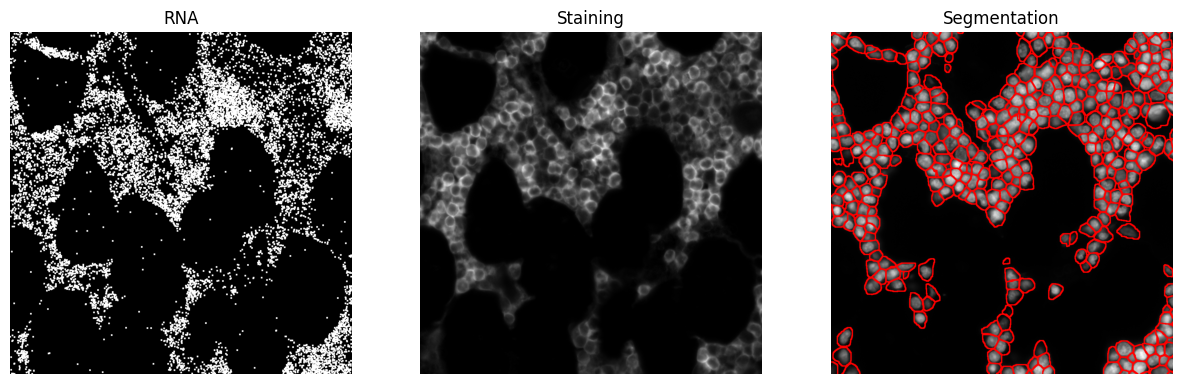

In [30]:
import matplotlib.pyplot as plt

# Parameters
key_segmentation="test_rnas2eg_cropped_patch1200_resize1024"
#bounds = [round(1700/0.2125), round(2400/0.2125), round(1900/0.2125), round(2600/0.2125),] # xmin, ymin, xmax, ymax
bounds = [1000, 1000, 2024, 2024]
staining_id = 1 # Staining to plot

# Get images
rna = dataset.get_rna_img(bounds, key_transcripts=points_key,)
image = dataset.get_staining_img(bounds)
seg = dataset.get_segmentation_img(bounds, key_cell=key_segmentation)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(rna)
axes[0].set_title("RNA")
axes[0].axis("off")

axes[1].imshow(image[staining_id], cmap="grey")
axes[1].set_title("Staining")
axes[1].axis("off")

axes[2].imshow(seg)
axes[2].set_title("Segmentation")
axes[2].axis("off")

plt.show()

#### Here are examples of different resizing parameters during dataset creation

Get RNA image ...
Get image ...
Get segmentation image ...


/data/chouw/Software/miniforge3/envs/rna2seg/lib/python3.10/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `test_rnas2eg_cropped_patch1200_resize512` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


Get image ...


100%|██████████| 204/204 [00:07<00:00, 28.56it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..3.0].


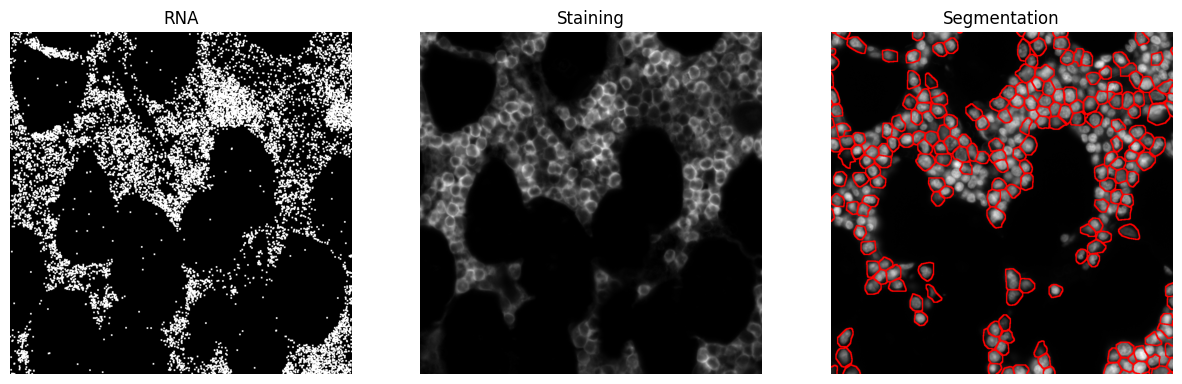

In [17]:
import matplotlib.pyplot as plt

# Parameters
key_segmentation="test_rnas2eg_cropped_patch1200_resize512"
#bounds = [round(1700/0.2125), round(2400/0.2125), round(1900/0.2125), round(2600/0.2125),] # xmin, ymin, xmax, ymax
bounds = [1000, 1000, 2024, 2024]
staining_id = 1 # Staining to plot

# Get images
rna = dataset.get_rna_img(bounds, key_transcripts=points_key,)
image = dataset.get_staining_img(bounds)
seg = dataset.get_segmentation_img(bounds, key_cell=key_segmentation)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(rna)
axes[0].set_title("RNA")
axes[0].axis("off")

axes[1].imshow(image[staining_id], cmap="grey")
axes[1].set_title("Staining")
axes[1].axis("off")

axes[2].imshow(seg)
axes[2].set_title("Segmentation")
axes[2].axis("off")

plt.show()

Get RNA image ...
Get image ...
Get segmentation image ...


/data/chouw/Software/miniforge3/envs/rna2seg/lib/python3.10/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `test_rnas2eg_cropped_patch1200_resize2048` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


Get image ...


100%|██████████| 379/379 [00:13<00:00, 28.68it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..3.0].


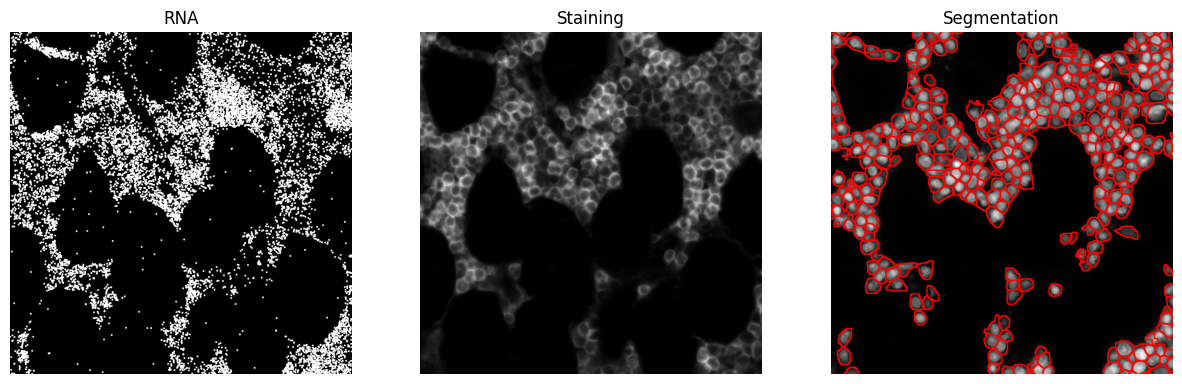

In [24]:
import matplotlib.pyplot as plt

# Parameters
key_segmentation="test_rnas2eg_cropped_patch1200_resize2048"
#bounds = [round(1700/0.2125), round(2400/0.2125), round(1900/0.2125), round(2600/0.2125),] # xmin, ymin, xmax, ymax
bounds = [1000, 1000, 2024, 2024]
staining_id = 1 # Staining to plot

# Get images
rna = dataset.get_rna_img(bounds, key_transcripts=points_key,)
image = dataset.get_staining_img(bounds)
seg = dataset.get_segmentation_img(bounds, key_cell=key_segmentation)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(rna)
axes[0].set_title("RNA")
axes[0].axis("off")

axes[1].imshow(image[staining_id], cmap="grey")
axes[1].set_title("Staining")
axes[1].axis("off")

axes[2].imshow(seg)
axes[2].set_title("Segmentation")
axes[2].axis("off")

plt.show()

Get RNA image ...
Get image ...
Get segmentation image ...


/data/chouw/Software/miniforge3/envs/rna2seg/lib/python3.10/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `test_rnas2eg_cropped_patch1200_resize512` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


Get image ...


100%|██████████| 204/204 [00:06<00:00, 31.67it/s]


Get segmentation image ...


/data/chouw/Software/miniforge3/envs/rna2seg/lib/python3.10/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `test_rnas2eg_cropped_patch1200_resize1024` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


Get image ...


100%|██████████| 391/391 [00:12<00:00, 31.74it/s]


Get segmentation image ...


/data/chouw/Software/miniforge3/envs/rna2seg/lib/python3.10/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `test_rnas2eg_cropped_patch1200_resize2048` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


Get image ...


100%|██████████| 379/379 [00:12<00:00, 31.57it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..3.0].


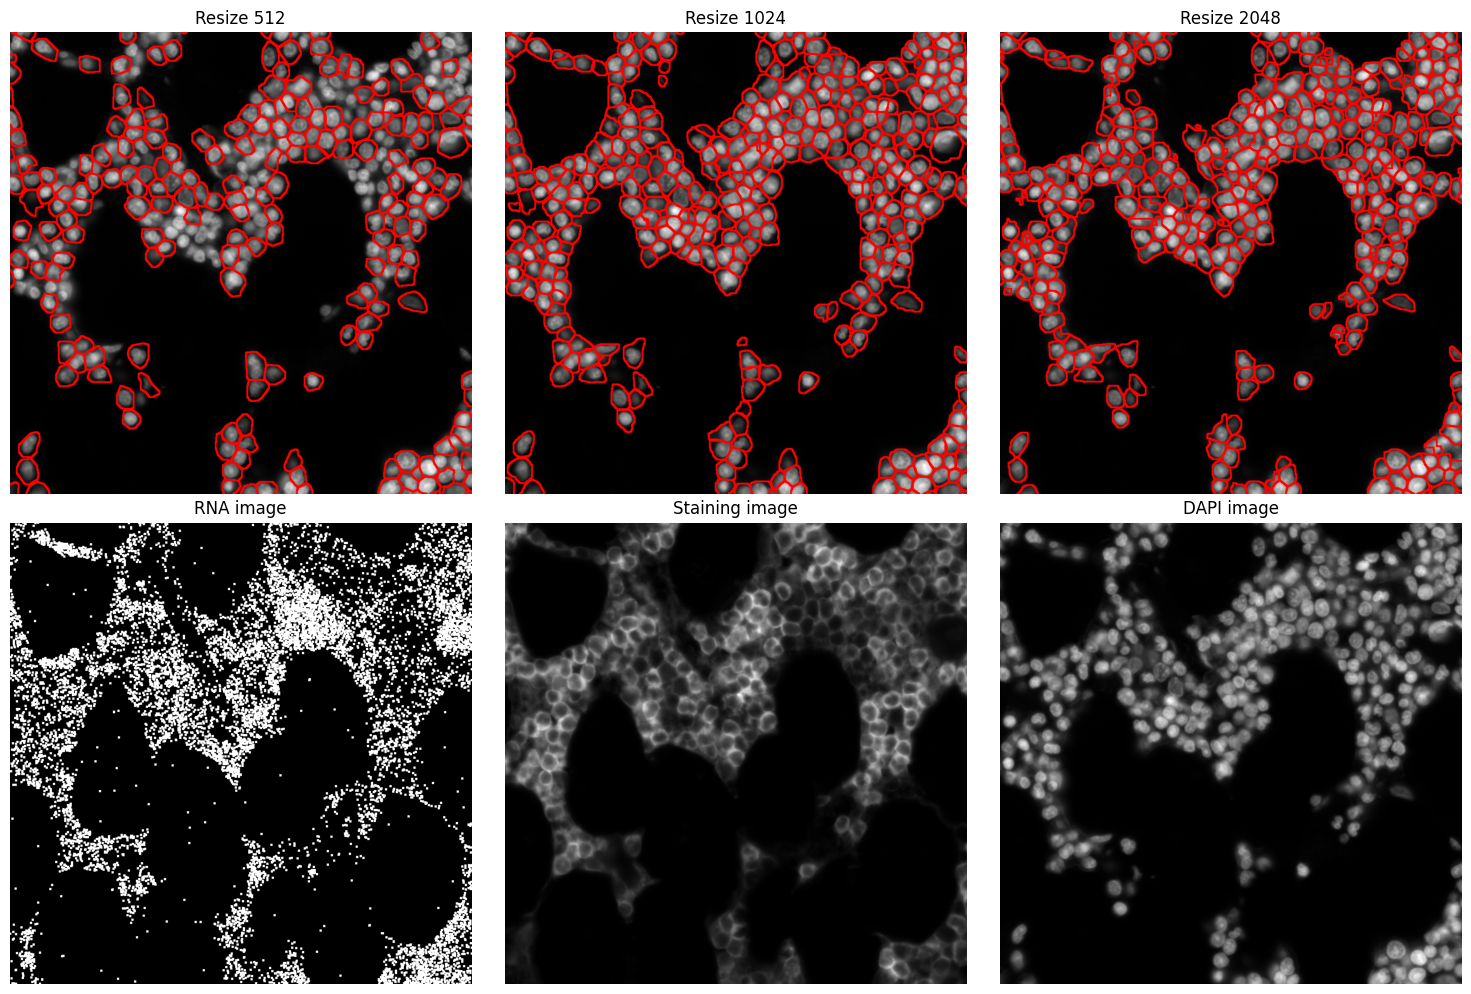

In [33]:
rna = dataset.get_rna_img(bounds, key_transcripts=points_key,)
image = dataset.get_staining_img(bounds)
seg = dataset.get_segmentation_img(bounds, key_cell="test_rnas2eg_cropped_patch1200_resize512")
seg1 = dataset.get_segmentation_img(bounds, key_cell="test_rnas2eg_cropped_patch1200_resize1024")
seg2 = dataset.get_segmentation_img(bounds, key_cell="test_rnas2eg_cropped_patch1200_resize2048")

# Plot
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes[0,0].imshow(seg)
axes[0,0].set_title("Resize 512")
axes[0,0].axis("off")

axes[0,1].imshow(seg1)
axes[0,1].set_title("Resize 1024")
axes[0,1].axis("off")

axes[0,2].imshow(seg2)
axes[0,2].set_title("Resize 2048")
axes[0,2].axis("off")

axes[1,0].imshow(rna)
axes[1,0].set_title("RNA image")
axes[1,0].axis("off")

axes[1,1].imshow(image[staining_id], cmap="grey")
axes[1,1].set_title("Staining image")
axes[1,1].axis("off")

axes[1,2].imshow(image[0], cmap="grey")
axes[1,2].set_title("DAPI image")
axes[1,2].axis("off")

plt.tight_layout()
plt.savefig("SN151_cropped_rna2seg_segmentation_resize_comparison.png", dpi=300)


# Run rns2seg on whole sample

In [ ]:
xe_data = sd.read_zarr('data/SN151/xenium.zarr')

image_key = "morphology_focus"
points_key = "transcripts"

channels_dapi= ["DAPI"]
channels_cellbound=["ATP1A1/CD45/E-Cadherin"]

gene_column_name="feature_name"

patch_width = 1200
patch_overlap = 150
min_points_per_patch = 0
folder_patch_rna2seg = Path(wd) / f".rna2seg_cropped{patch_width}_{patch_overlap}"

In [ ]:
from rna2seg.dataset_zarr.patches import create_patch_rna2seg

### create patch in the sdata and precompute transcipt.csv for each patch with sopa
create_patch_rna2seg(sdata=cropped_sdata,
                    image_key=image_key,
                    points_key=points_key,
                    patch_width=patch_width,
                    patch_overlap=patch_overlap,
                    min_points_per_patch=min_points_per_patch,
                    folder_patch_rna2seg = folder_patch_rna2seg,
                    overwrite = True,
                    gene_column_name=gene_column_name)

In [ ]:
import albumentations as A
from rna2seg.dataset_zarr import RNA2segDataset
resize_dim = 1024

transform_resize  = A.Compose([
    A.Resize(width=resize_dim, height=resize_dim, interpolation=cv2.INTER_NEAREST),
])

dataset = RNA2segDataset(
    sdata=cropped_sdata,
    channels_dapi=channels_dapi,
    channels_cellbound=channels_cellbound,
    patch_width = patch_width,
    patch_overlap = patch_overlap,
    gene_column=gene_column_name,
    transform_resize = transform_resize,
    patch_dir=folder_patch_rna2seg
)

In [ ]:
from rna2seg.models import RNA2seg
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"


rna2seg = RNA2seg(
    device,
    net='unet',
    flow_threshold = 0.9,
    cellbound_flow_threshold = 0.4,
    pretrained_model = "default_pretrained"
)

In [ ]:
from tqdm import tqdm
from rna2seg.utils import save_shapes2zarr

for i in tqdm(range(len(dataset))):
    input_dict = dataset[i]
    rna2seg.run(
        path_temp_save=folder_patch_rna2seg,
        input_dict=input_dict
    )

In [ ]:
segmentation_shape_name = "test_rnas2eg_cropped_patch1200_resize1024"
save_shapes2zarr(dataset=dataset,
                 path_parquet_files=folder_patch_rna2seg,
                 segmentation_key=segmentation_shape_name,
                 overwrite = True
                 )
cropped_sdata

Get RNA image ...
Get image ...
Get segmentation image ...
Get image ...


/data/chouw/Software/miniforge3/envs/rna2seg/lib/python3.10/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `test_rnas2eg_1200resize1024` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
100%|██████████| 375/375 [00:11<00:00, 31.70it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..3.0].


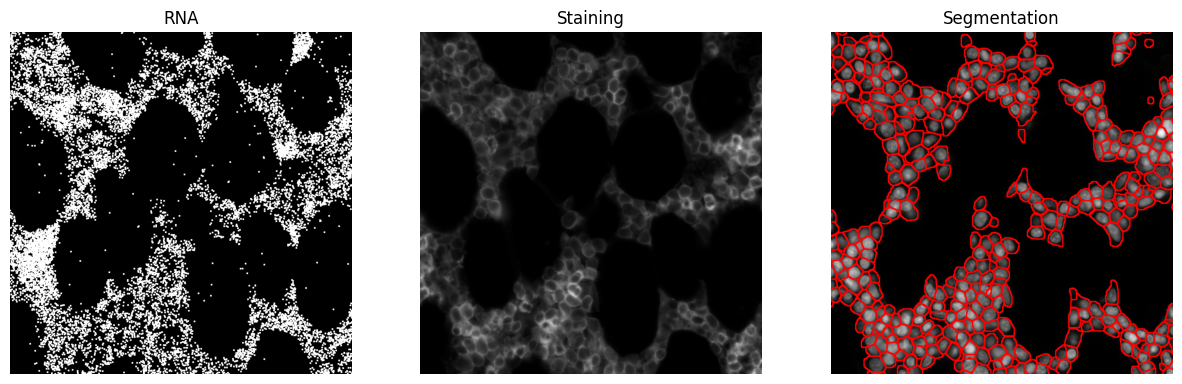

In [39]:
# Parameters
key_segmentation="test_rnas2eg_1200resize1024"
#bounds = [round(1700/0.2125), round(2400/0.2125), round(1900/0.2125), round(2600/0.2125),] # xmin, ymin, xmax, ymax
bounds = [6000, 12000, 7024, 13024]
staining_id = 1 # Staining to plot

# Get images
rna = dataset.get_rna_img(bounds, key_transcripts=points_key,)
image = dataset.get_staining_img(bounds)
seg = dataset.get_segmentation_img(bounds, key_cell=key_segmentation)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(rna)
axes[0].set_title("RNA")
axes[0].axis("off")

axes[1].imshow(image[staining_id], cmap="grey")
axes[1].set_title("Staining")
axes[1].axis("off")

axes[2].imshow(seg)
axes[2].set_title("Segmentation")
axes[2].axis("off")

plt.show()


Get RNA image ...
Get image ...
Get segmentation image ...
Get image ...


/data/chouw/Software/miniforge3/envs/rna2seg/lib/python3.10/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `test_rnas2eg_1200resize1024` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
100%|██████████| 375/375 [00:12<00:00, 30.22it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..3.0].


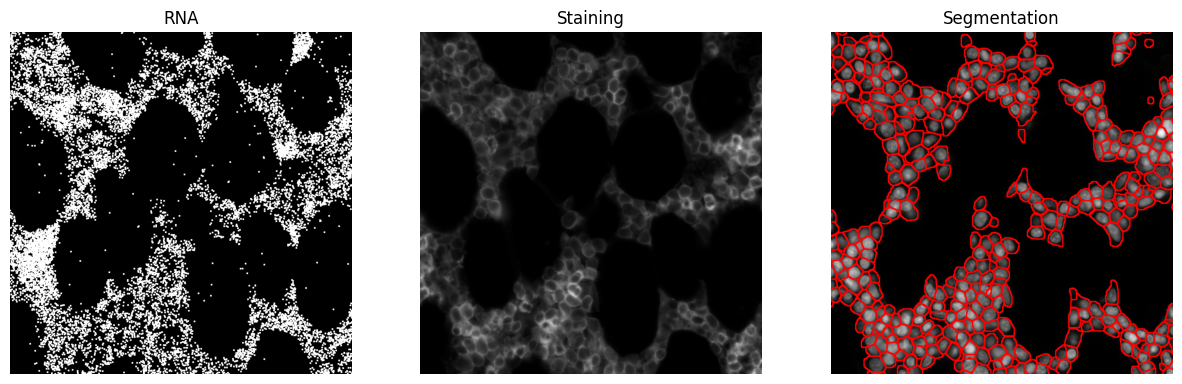

In [13]:
import matplotlib.pyplot as plt
# Parameters
key_segmentation="test_rnas2eg_1200resize1024"
#bounds = [round(1700/0.2125), round(2400/0.2125), round(1900/0.2125), round(2600/0.2125),] # xmin, ymin, xmax, ymax
bounds = [6000, 12000, 7024, 13024]
staining_id = 1 # Staining to plot

# Get images
rna = dataset.get_rna_img(bounds, key_transcripts=points_key,)
image = dataset.get_staining_img(bounds)
seg = dataset.get_segmentation_img(bounds, key_cell=key_segmentation)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(rna)
axes[0].set_title("RNA")
axes[0].axis("off")

axes[1].imshow(image[staining_id], cmap="grey")
axes[1].set_title("Staining")
axes[1].axis("off")

axes[2].imshow(seg)
axes[2].set_title("Segmentation")
axes[2].axis("off")

plt.show()

Get image ...
Get RNA image ...


/data/chouw/Software/miniforge3/envs/rna2seg/lib/python3.10/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `test_rnas2eg_1200resize1024` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


Get segmentation image ...
Get image ...


100%|██████████| 375/375 [00:12<00:00, 30.15it/s]


Get segmentation image ...


/data/chouw/Software/miniforge3/envs/rna2seg/lib/python3.10/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `cell_boundaries` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


Get image ...


100%|██████████| 375/375 [00:12<00:00, 30.25it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..3.0].


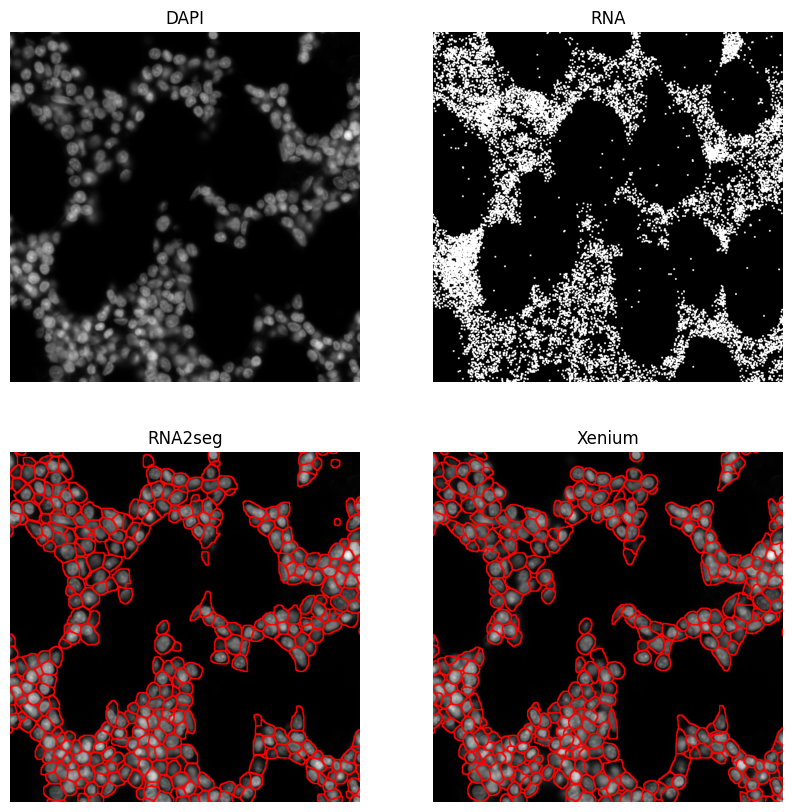

In [15]:
## Compare rna2seg and Xenium segmentation
# Get images
bounds = [6000, 12000, 7024, 13024]

image = dataset.get_staining_img(bounds)
rna = dataset.get_rna_img(bounds, key_transcripts=points_key,)
seg_rna2seg = dataset.get_segmentation_img(bounds, key_cell="test_rnas2eg_1200resize1024")
seg_xenium = dataset.get_segmentation_img(bounds, key_cell="cell_boundaries")

# Plot
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes[0,0].imshow(image[0], cmap="grey")
axes[0,0].set_title("DAPI")
axes[0,0].axis("off")

axes[0,1].imshow(rna)
axes[0,1].set_title("RNA")
axes[0,1].axis("off")

axes[1,0].imshow(seg_rna2seg)
axes[1,0].set_title("RNA2seg")
axes[1,0].axis("off")

axes[1,1].imshow(seg_xenium)
axes[1,1].set_title("Xenium")
axes[1,1].axis("off")

plt.show()

### Export new segmentation boundaries for Xenium Ranger processing

In [ ]:
segmentation_gdf = xe_data['test_rnas2eg_1200resize1024']
output_geojson_path = 'rna2seg_1200resize1024.geojson'

segmentation_gdf.to_file(output_geojson_path, driver='GeoJSON')

print(f"Segmentation GeoDataFrame exported to: {output_geojson_path}")